https://datawhalechina.github.io/llm-cookbook/#/C4/3.%20%E6%96%87%E6%A1%A3%E5%88%86%E5%89%B2%20Splitting

## 问什么要进行文档分割

1. 模型大小和内存限制：GPT 模型，具有数十亿甚至上百亿的参数。为了在一次前向传播中处理这么多的参数，需要大量的计算能力和内存。但是，大多数硬件设备（例如 GPU 或 TPU ）有内存限制。文档分割使模型能够在这些限制内工作。
2. 计算效率：处理更长的文本序列需要更多的计算资源。通过将长文档分割成更小的块，可以更高效地进行计算。
3. 序列长度限制：GPT 模型有一个固定的最大序列长度，例如2048个 token 。这意味着模型一次只能处理这么多 token 。对于超过这个长度的文档，需要进行分割才能被模型处理。
4. 更好的泛化：通过在多个文档块上进行训练，模型可以更好地学习和泛化到各种不同的文本样式和结构。
5. 数据增强：分割文档可以为训练数据提供更多的样本。例如，一个长文档可以被分割成多个部分，并分别作为单独的训练样本。

需要注意的是，虽然文档分割有其优点，但也可能导致一些上下文信息的丢失，尤其是在分割点附近。因此，如何进行文档分割是一个需要权衡的问题。

## 文档分割方式
Langchain 中文本分割器都根据 chunk_size (块大小)和 chunk_overlap (块与块之间的重叠大小)进行分割。

* chunk_size 指每个块包含的字符或 Token （如单词、句子等）的数量
* chunk_overlap 指两个块之间共享的字符数量，用于保持上下文的连贯性，避免分割丢失上下文信息

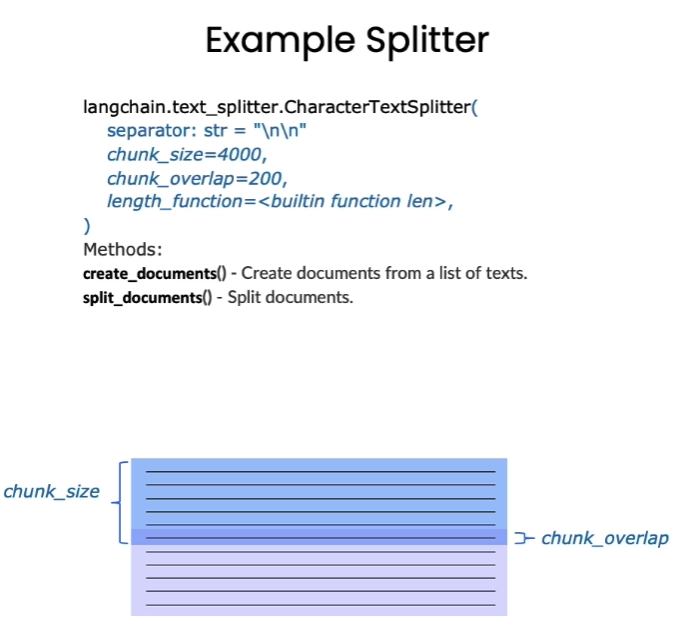

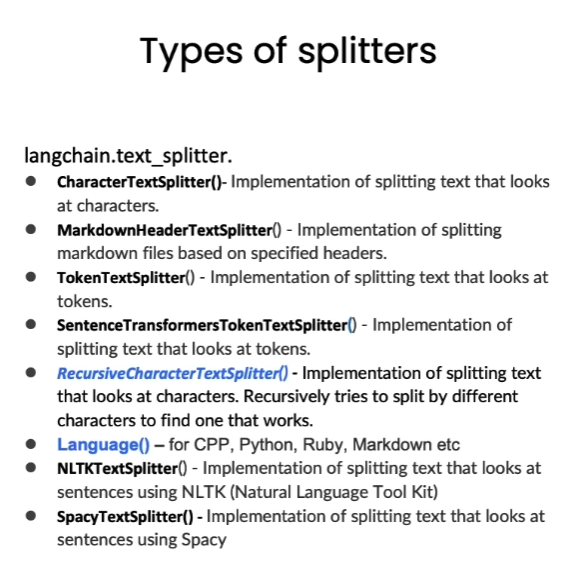

## 基于字符分割

* CharacterTextSplitter 是字符文本分割，分隔符的参数是单个的字符串；

* RecursiveCharacterTextSplitter 是递归字符文本分割，将按不同的字符递归地分割（按照这个优先级["\n\n", "\n", " ", ""]），这样就能尽量把所有和语义相关的内容尽可能长时间地保留在同一位置。因此，*

  RecursiveCharacterTextSplitter 比 CharacterTextSplitter 对文档切割得更加碎片化

  RecursiveCharacterTextSplitter 需要关注的是如下4个参数：

  * separators - 分隔符字符串数组
  * chunk_size - 每个文档的字符数量限制
  * chunk_overlap - 两份文档重叠区域的长度
  * length_function - 长度计算函数

In [1]:
# 导入文本分割器
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

chunk_size = 20 #设置块大小
chunk_overlap = 10 #设置块重叠大小

# 初始化递归字符文本分割器
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)
# 初始化字符文本分割器
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)


In [2]:
text = "在AI的研究中，由于大模型规模非常大，模型参数很多，在大模型上跑完来验证参数好不好训练时间成本很高，所以一般会在小模型上做消融实验来验证哪些改进是有效的再去大模型上做实验。"  #测试文本
r_splitter.split_text(text)

['在AI的研究中，由于大模型规模非常大，模',
 '大模型规模非常大，模型参数很多，在大模型',
 '型参数很多，在大模型上跑完来验证参数好不',
 '上跑完来验证参数好不好训练时间成本很高，',
 '好训练时间成本很高，所以一般会在小模型上',
 '所以一般会在小模型上做消融实验来验证哪些',
 '做消融实验来验证哪些改进是有效的再去大模',
 '改进是有效的再去大模型上做实验。']

In [3]:
#字符文本分割器
c_splitter.split_text(text)

['在AI的研究中，由于大模型规模非常大，模型参数很多，在大模型上跑完来验证参数好不好训练时间成本很高，所以一般会在小模型上做消融实验来验证哪些改进是有效的再去大模型上做实验。']

可以看到字符分割器没有分割这个文本，因为字符文本分割器默认以换行符为分隔符，因此需要设置“，”为分隔符。

In [4]:
# 设置空格分隔符
c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separator='，'
)
c_splitter.split_text(text)


Created a chunk of size 23, which is longer than the specified 20


['在AI的研究中，由于大模型规模非常大',
 '由于大模型规模非常大，模型参数很多',
 '在大模型上跑完来验证参数好不好训练时间成本很高',
 '所以一般会在小模型上做消融实验来验证哪些改进是有效的再去大模型上做实验。']

## 基于Token 分割

很多 LLM 的上下文窗口长度限制是按照 Token 来计数的。因此，以 LLM 的视角，按照 Token 对文本进行分隔，通常可以得到更好的结果。 通过一个实例理解基于字符分割和基于 Token 分割的区别

In [6]:
# 使用token分割器进行分割，
# 将块大小设为1，块重叠大小设为0，相当于将任意字符串分割成了单个Token组成的列
from langchain.text_splitter import TokenTextSplitter
text_splitter = TokenTextSplitter(chunk_size=1, chunk_overlap=0)
text = "foo bar bazzyfoo"
text_splitter.split_text(text)
# 注：目前 LangChain 基于 Token 的分割器还不支持中文


['foo', ' bar', ' b', 'az', 'zy', 'foo']

## 分割 Markdown 文档
分块的目的是把具有上下文的文本放在一起

In [26]:
# 定义一个Markdown文档

from langchain.document_loaders import NotionDirectoryLoader#Notion加载器
from langchain.text_splitter import MarkdownHeaderTextSplitter#markdown分割器

markdown_document = """# Title\n\n \
## 第一章\n\n \
李白乘舟将欲行\n\n 忽然岸上踏歌声\n\n \
### Section \n\n \
桃花潭水深千尺 \n\n 
## 第二章\n\n \
不及汪伦送我情"""

# 定义想要分割的标题列表和名称
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)#message_typemessage_type
md_header_splits = markdown_splitter.split_text(markdown_document)

print("第一个块")
print(md_header_splits[0])
print("第二个块")
print(md_header_splits[1])



第一个块
page_content='李白乘舟将欲行  
忽然岸上踏歌声' metadata={'Header 1': 'Title', 'Header 2': '第一章'}
第二个块
page_content='桃花潭水深千尺' metadata={'Header 1': 'Title', 'Header 2': '第一章', 'Header 3': 'Section'}


In [13]:
from langchain.document_loaders import NotionDirectoryLoader

#加载数据库的内容
loader = NotionDirectoryLoader("docs")
docs = loader.load()
txt = ' '.join([d.page_content for d in docs])#拼接文档

headers_to_split_on = [
    ("###", "Header 1"),
    ("###", "Header 2"),
]
#加载文档分割器
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)

md_header_splits = markdown_splitter.split_text(txt)#分割文本内容

print(md_header_splits)#分割结果


[Document(page_content='# LangChain框架  \nLangChain作为一个框架由许多包组成。'), Document(metadata={'Header 1': '**`langchain-core`**'}, page_content='该包包含不同组件的基本抽象以及将它们组合在一起的方法。此处定义了 LLMs、向量存储、检索器等核心组件的接口。此处未定义第三方集成。依赖项有目的地保持非常轻量级。'), Document(metadata={'Header 1': '`langchain-community`'}, page_content='[组件](https://www.notion.so/bf496f1303dc4044870b2e47131a9b25?pvs=21)')]
